# Daten einlesen und Pipeline definieren

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score



def r2(actual: np.ndarray, predicted: np.ndarray):
    """ R2 Score """
    return r2_score(actual, predicted)
def adjr2(actual: np.ndarray, predicted: np.ndarray, rowcount: int, featurecount: int):
    """ R2 Score """
    return 1-(1-r2(actual,predicted))*(rowcount-1)/(rowcount-featurecount)

# 1. Daten einlesen und zusammenführen
df1 = pd.read_csv('../umsatzdaten_gekuerzt.csv')
df2 = pd.read_csv('../wetter.csv')
df3 = pd.read_csv('../kiwo.csv')
df4 = pd.read_csv('../Feier_Bruecke_Ferien_bis2018.csv')

df = df1.merge(df2, on='Datum', how='left')
df = df.merge(df3, on='Datum', how='left')
df = df.merge(df4, on='Datum', how='left')

# replace NaN with False for 'KielerWoche'
df['KielerWoche'] = df['KielerWoche'].fillna(False)
df['KielerWoche'] = df['KielerWoche'].astype('bool')

# Sicherstellen, dass 'Datum' als datetime konvertiert ist
df['Datum'] = pd.to_datetime(df['Datum'])

# 2. Pipeline-Komponenten definieren

# a) Feature Engineering: Erstellen von Datum- und zyklischen Features
def add_features(df):
    # df = df.copy()
    # Basismerkmale
    df['Jahr'] = df['Datum'].dt.year
    df['Monat'] = df['Datum'].dt.month
    df['Wochentag'] = df['Datum'].dt.weekday
    df['Kalenderwoche'] = df['Datum'].dt.isocalendar().week
    df['Tag_im_Jahr'] = df['Datum'].dt.dayofyear
    df['Ist_Wochenende'] = df['Wochentag'].isin([5, 6]).astype(int)
    
    # Zyklische Merkmale
    df['Tag_im_Jahr_sin'] = np.sin(2 * np.pi * df['Tag_im_Jahr'] / 365)
    df['Tag_im_Jahr_cos'] = np.cos(2 * np.pi * df['Tag_im_Jahr'] / 365)
    df['Monat_sin'] = np.sin(2 * np.pi * df['Monat'] / 12)
    df['Monat_cos'] = np.cos(2 * np.pi * df['Monat'] / 12)
    df['Wochentag_sin'] = np.sin(2 * np.pi * df['Wochentag'] / 7)
    df['Wochentag_cos'] = np.cos(2 * np.pi * df['Wochentag'] / 7)
        
    return df

df = add_features(df)
# b) FunctionTransformer für Feature Engineering
feature_engineering = FunctionTransformer(add_features, validate=False)

# c) Definieren der Feature-Gruppen
numeric_features = ['Temperatur', 'Bewoelkung', 'Windgeschwindigkeit',
                    'Tag_im_Jahr_sin', 'Tag_im_Jahr_cos',
                    'Monat_sin', 'Monat_cos',
                    'Wochentag_sin', 'Wochentag_cos','feiertag', 'KielerWoche',
                    'brueckentag', 'BW', 'BY', 'B', 'BB', 'HB', 'HH', 'HE', 'MV',
                      'NI', 'NW', 'RP', 'SL', 'SN', 'ST', 'SH', 'TH']
                    
categorical_features = ['Warengruppe', 'Wettercode', 'Wochentag']

# d) Definieren des ColumnTransformers
# Stellen Sie sicher, dass 'Wettercode' als String vorliegt
df['Wettercode'] = df['Wettercode'].astype(str)

# Liste der Kategorien für 'Wettercode'
wettercode_categories = [str(i) for i in range(0, 100)] + ['Unbekannt']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        
        ('wettercode', OneHotEncoder(categories=[wettercode_categories], handle_unknown='ignore'), ['Wettercode']),
        
        ('warengruppe', OneHotEncoder(handle_unknown='ignore'), ['Warengruppe']),
        
        ('wochentag', OneHotEncoder(handle_unknown='ignore'), ['Wochentag'])
    ],
    remainder='drop'
)

# Define your date thresholds
train_end_date = '2017-07-31'
validation_end_date = '2018-07-31'

train_data = df[df['Datum'] <= train_end_date]
test_data = df[df['Datum'] > train_end_date]

df = df.drop('Datum', axis=1)
df = df.drop('id', axis=1)

X = df.drop(['Umsatz'], axis=1)
y = df['Umsatz']

X_train  = train_data.drop(['Umsatz'], axis=1)  # Behalten Sie 'Datum' in X für die Pipeline
y_train = train_data['Umsatz']

X_test  = test_data.drop(['Umsatz'], axis=1)  # Behalten Sie 'Datum' in X für die Pipeline
y_test = test_data['Umsatz']


In [7]:
df.columns.size

37

In [5]:
df.head

<bound method NDFrame.head of            id  Warengruppe      Umsatz  Bewoelkung  Temperatur  \
0     1307011            1  148.828353         6.0     17.8375   
1     1307021            1  159.793757         3.0     17.3125   
2     1307031            1  111.885594         7.0     21.0750   
3     1307041            1  168.864941         7.0     18.8500   
4     1307051            1  171.280754         5.0     19.9750   
...       ...          ...         ...         ...         ...   
9329  1712216            6   87.471228         7.0      6.2375   
9330  1712226            6   71.911652         7.0      5.7625   
9331  1712236            6   84.062223         7.0      7.8000   
9332  1712246            6   60.981969         7.0      8.1125   
9333  1712276            6   34.972644         7.0      4.6125   

      Windgeschwindigkeit Wettercode  KielerWoche  feiertag  brueckentag  ...  \
0                    15.0       20.0        False         0            0  ...   
1              

# Linear Regression

In [6]:
from sklearn.linear_model import LinearRegression

pipeline_1 = Pipeline(steps=[
    ('feature_engineering', feature_engineering),
    ('preprocessing', preprocessor),
    ('model',  LinearRegression())
])
pipeline_1.fit(X_train, y_train)

lr_y_pred = pipeline_1.predict(X_test)



print("R² on test:", r2_score(y_test, lr_y_pred))
print("adjusted R² on test:", adjr2(y_test, lr_y_pred, len(df), df.drop(['Umsatz'], axis=1) .shape[1]))

R² on test: 0.7360924544022935
adjusted R² on test: 0.7350705471589336


# RandomForestRegressor

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

pipeline = Pipeline(steps=[
    ('feature_engineering', feature_engineering),
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# 4. Modell trainieren
pipeline.fit(X_train, y_train)

# 5. Vorhersagen treffen und evaluieren
y_pred = pipeline.predict(X_test)
print("R² on test:", r2_score(y_test, y_pred))
print("adjusted R² on test:", adjr2(y_test, lr_y_pred, len(y), X.shape[1]))

NameError: name 'Pipeline' is not defined

# GridSearchCV

In [ ]:

# 6. Hyperparameter-Tuning (optional)
param_grid = {
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [None, 10, 20, 50],
    'model__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best RF Params:", grid_search.best_params_)
y_pred_best = grid_search.predict(X_test)
print("Test R² Best RF:", r2_score(y_test, y_pred_best))

# Neuronales Netz nutzen

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


# Transformation der Daten
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Überprüfen der Dimensionen der transformierten Daten
input_shape = X_train_preprocessed.shape[1]


model = Sequential([
  InputLayer(shape=(input_shape, )),
  BatchNormalization(),
  Dense(72, activation='relu'),
  Dropout(0.2),  # Regularisierung
  Dense(36, activation='relu'),
  Dropout(0.2),  # Regularisierung
  Dense(18, activation='relu'),
  Dense(1, activation='linear')
])

model.summary()

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Training
history = model.fit(
    X_train_preprocessed,
    y_train,
    validation_data=(X_test_preprocessed, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

y_pred = model.predict(X_test_preprocessed)
print("R² on test:", r2_score(y_test, y_pred))
print("adjusted R² on test:", adjr2(y_test, y_pred, len(y), X.shape[1]))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 142)            │           568 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 72)             │        10,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 72)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │         2,628 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │           666 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,177 (55.38 KB)

 Trainable params: 13,893 (54.27 KB)

 Non-trainable params: 284 (1.11 KB)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 44264.1719 - mae: 158.1921 - val_loss: 4454.9487 - val_mae: 45.6319
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6850.1270 - mae: 53.7483 - val_loss: 4573.2520 - val_mae: 47.8858
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 5921.6963 - mae: 50.7644 - val_loss: 3366.3694 - val_mae: 39.3323
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5810.2925 - mae: 48.2554 - val_loss: 3027.0505 - val_mae: 36.9015
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6383.1523 - mae: 47.8939 - val_loss: 2521.7966 - val_mae: 31.9162
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5458.9946 - mae: 46.2278 - val_loss: 3864.0134 - val_mae: 43.8375
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 5434.4536 - mae: 46.0612 - val_loss: 2504.2390 - val_mae: 31.6656
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5981.8584 - mae: 45.0408 - val_loss: 2475.6836 - val

NameError: name 'adjr2' is not defined

In [6]:
print("R² on test:", r2_score(y_test, y_pred))
print("adjusted R² on test:", adjr2(y_test, y_pred, len(y), X.shape[1]))

R² on test: 0.8170576777084342
adjusted R² on test: 0.8163690370028841


# Performance evaluieren

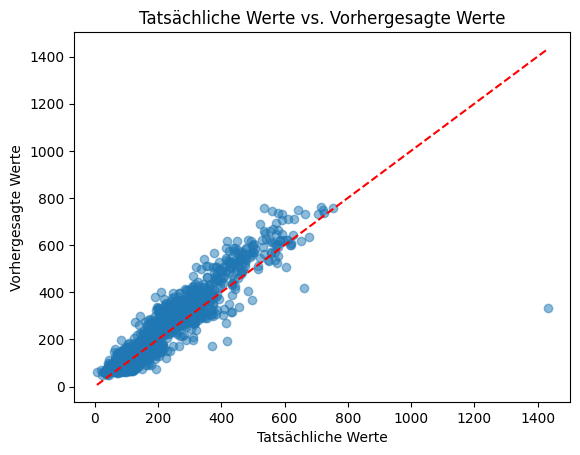

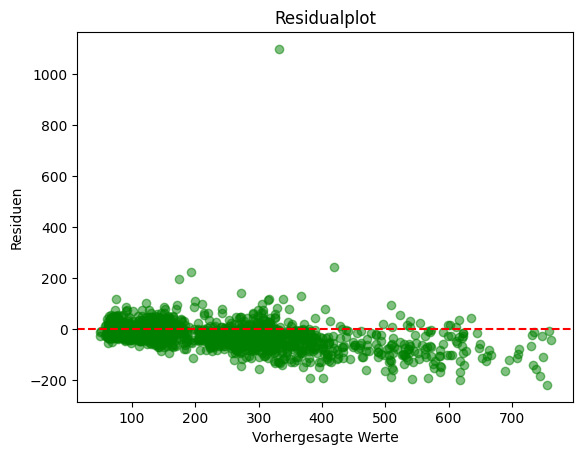

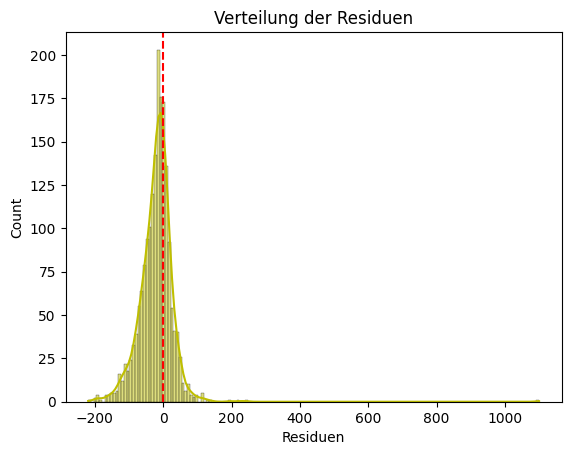

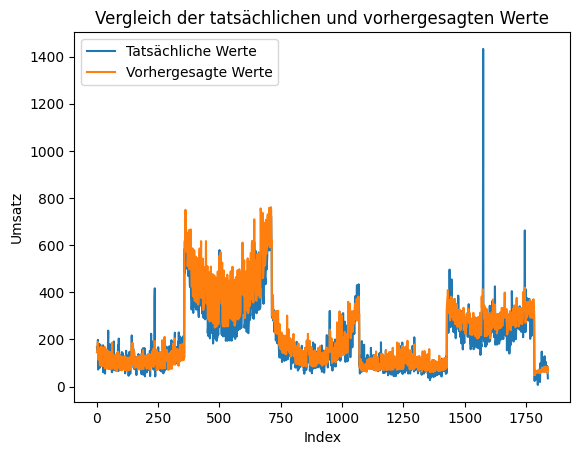

In [9]:
import matplotlib.pyplot as plt

# Flatten y_pred
y_pred_flat = y_pred.flatten()

# Scatterplot
plt.scatter(y_test, y_pred_flat, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonale Linie
plt.xlabel("Tatsächliche Werte")
plt.ylabel("Vorhergesagte Werte")
plt.title("Tatsächliche Werte vs. Vorhergesagte Werte")
plt.show()

residuals = y_test - y_pred_flat

# Residualplot
plt.scatter(y_pred_flat, residuals, alpha=0.5, color='g')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Vorhergesagte Werte")
plt.ylabel("Residuen")
plt.title("Residualplot")
plt.show()

import seaborn as sns

# Histogramm der Residuen
sns.histplot(residuals, kde=True, color='y')
plt.axvline(0, color='r', linestyle='--')
plt.xlabel("Residuen")
plt.title("Verteilung der Residuen")
plt.show()

plt.plot(y_test.values, label="Tatsächliche Werte")
plt.plot(y_pred_flat, label="Vorhergesagte Werte")
plt.legend()
plt.xlabel("Index")
plt.ylabel("Umsatz")
plt.title("Vergleich der tatsächlichen und vorhergesagten Werte")
plt.show()

# Modell auf Submission-Datensatz laufen lassen

In [14]:
## Submission vorbereiten


df_sub = pd.read_csv('../sample_submission.csv')

# Angenommen, die Jahre sind 20xx:
df_sub['id'] = df_sub['id'].astype('string')
df_sub['Tag'] = df_sub['id'].str[0:2]
df_sub['Monat'] = df_sub['id'].str[2:4]
df_sub['Jahr'] = '20' + df_sub['id'].str[4:6]  # falls im Format YY z. B. 01 → 2001 oder 20xx

df_sub['Warengruppe'] = df_sub['id'].str[6]  # letztes Zeichen
df_sub['Warengruppe'] = df_sub['Warengruppe'].astype(int)

# Ein Datum aus Tag, Monat, Jahr erzeugen:
df_sub.rename(columns={'Jahr':'year', 'Monat':'month', 'Tag':'day'}, inplace=True)
df_sub['Datum'] = pd.to_datetime(df_sub[['year','month','day']])
df2['Datum'] = pd.to_datetime(df2['Datum'])
df3['Datum'] = pd.to_datetime(df3['Datum'])
df4['Datum'] = pd.to_datetime(df4['Datum'])
df_sub = df_sub.merge(df4, on='Datum', how='left')
df_sub = df_sub.merge(df3, on='Datum', how='left')
df_sub = df_sub.merge(df2, on='Datum', how='left')

df_sub['Wochentag'] = df_sub['Datum'].dt.weekday
df_sub['Ist_Wochenende'] = df_sub['Wochentag'].isin([5,6])
df_sub['Monat'] = df_sub['Datum'].dt.month
df_sub['Monat_sin'] = np.sin(2 * np.pi * df_sub['Monat']/12)
df_sub['Monat_cos'] = np.cos(2 * np.pi * df_sub['Monat']/12)

# Check if all data types are correctly set for all variables
print('### Initial datatypes')
print(df_sub.dtypes)

# Set the correct types for all variables

df_sub['Wettercode'] = df_sub['Wettercode'].astype('category')
df_sub['Warengruppe'] = df_sub['Warengruppe'].astype('category')


# replace NaN with False for 'KielerWoche'
df_sub['KielerWoche'] = df_sub['KielerWoche'].fillna(False)
df_sub['KielerWoche'] = df_sub['KielerWoche'].astype('bool')
print('### Corrected datatypes')
print(df_sub.dtypes)


# Datum in Datetime konvertieren
df_sub['Datum'] = pd.to_datetime(df_sub['Datum'])

# Basismerkmale
df_sub['Jahr'] = df_sub['Datum'].dt.year
df_sub['Monat'] = df_sub['Datum'].dt.month
df_sub['Wochentag'] = df_sub['Datum'].dt.weekday
df_sub['Kalenderwoche'] = df_sub['Datum'].dt.isocalendar().week
df_sub['Tag_im_Jahr'] = df_sub['Datum'].dt.dayofyear
df_sub['Tag_im_Jahr_sin'] = np.sin(2 * np.pi * df_sub['Tag_im_Jahr'] / 365)
df_sub['Tag_im_Jahr_cos'] = np.cos(2 * np.pi * df_sub['Tag_im_Jahr'] / 365)
df_sub['Ist_Wochenende'] = df_sub['Wochentag'].isin([5, 6]).astype(int)


# Zyklische Merkmale
df_sub['Monat_sin'] = np.sin(2 * np.pi * df_sub['Monat'] / 12)
df_sub['Monat_cos'] = np.cos(2 * np.pi * df_sub['Monat'] / 12)
df_sub['Wochentag_sin'] = np.sin(2 * np.pi * df_sub['Wochentag'] / 7)
df_sub['Wochentag_cos'] = np.cos(2 * np.pi * df_sub['Wochentag'] / 7)


# Beispiel für Mittelwert-Imputation
df_sub['Temperatur'].fillna(df_sub['Temperatur'].mean(), inplace=True)
df_sub['Bewoelkung'].fillna(df_sub['Bewoelkung'].mean(), inplace=True)
df_sub['Windgeschwindigkeit'].fillna(df_sub['Windgeschwindigkeit'].mean(), inplace=True)

df_sub['Wettercode'] = df_sub['Wettercode'].cat.add_categories(['Unbekannt'])
df_sub['Wettercode'] = df_sub['Wettercode'].fillna('Unbekannt')


# Sicherstellen, dass 'Datum' als datetime konvertiert ist
#df['Datum'] = pd.to_datetime(df['Datum'])



# 5. Vorhersagen treffen und evaluieren
y_pred_sub = model.predict(df_sub)
#y_pred_sub_best = grid_search.predict(df_sub)

df_sub['Umsatz'] = y_pred_sub

# Erstellen der finalen Submission:
df_sub[['id','Umsatz']].to_csv('../nr_submission.csv', index=False)

### Initial datatypes
id                     string[python]
Umsatz                          int64
day                    string[python]
month                  string[python]
year                   string[python]
Warengruppe                     int64
Datum                  datetime64[ns]
feiertag                      float64
brueckentag                   float64
BW                            float64
BY                            float64
B                             float64
BB                            float64
HB                            float64
HH                            float64
HE                            float64
MV                            float64
NI                            float64
NW                            float64
RP                            float64
SL                            float64
SN                            float64
ST                            float64
SH                            float64
TH                            float64
KielerWoche                 

/var/folders/tv/qpxdljv13vd6jxppkbwll56w0000gn/T/ipykernel_39154/73201599.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sub['Temperatur'].fillna(df_sub['Temperatur'].mean(), inplace=True)
/var/folders/tv/qpxdljv13vd6jxppkbwll56w0000gn/T/ipykernel_39154/73201599.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

ValueError: Invalid dtype: category

# MAPE

In [17]:


def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE)
    
    Parameters:
    y_true (array-like): Actual values
    y_pred (array-like): Predicted values
    
    Returns:
    float: MAPE value
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Ensure y_pred has the same number of elements as y_test
y_pred = model.predict(X_test_preprocessed).flatten()

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape}%")

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAPE: 21.456639263578094%


# Submission v2

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


def r2(actual: np.ndarray, predicted: np.ndarray):
    """ R2 Score """
    return r2_score(actual, predicted)

def adjr2(actual: np.ndarray, predicted: np.ndarray, rowcount: int, featurecount: int):
    """ Adjusted R2 Score """
    return 1-(1-r2(actual,predicted))*(rowcount-1)/(rowcount-featurecount)

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE)
    
    Parameters:
    y_true (array-like): Actual values
    y_pred (array-like): Predicted values
    
    Returns:
    float: MAPE value
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 1. Daten einlesen und zusammenführen
df1 = pd.read_csv('../umsatzdaten_gekuerzt.csv')
df2 = pd.read_csv('../wetter.csv')
df3 = pd.read_csv('../kiwo.csv')
df4 = pd.read_csv('../Feier_Bruecke_Ferien_bis2018.csv')

df = df1.merge(df2, on='Datum', how='left')
df = df.merge(df3, on='Datum', how='left')
df = df.merge(df4, on='Datum', how='left')

# replace NaN with False for 'KielerWoche'
df['KielerWoche'] = df['KielerWoche'].fillna(False)
df['KielerWoche'] = df['KielerWoche'].astype('bool')

# Sicherstellen, dass 'Datum' als datetime konvertiert ist
df['Datum'] = pd.to_datetime(df['Datum'])

# a) Feature Engineering: Erstellen von Datum- und zyklischen Features
def add_features(df):
    df['Jahr'] = df['Datum'].dt.year
    df['Monat'] = df['Datum'].dt.month
    df['Wochentag'] = df['Datum'].dt.weekday
    df['Kalenderwoche'] = df['Datum'].dt.isocalendar().week
    df['Tag_im_Jahr'] = df['Datum'].dt.dayofyear
    df['Ist_Wochenende'] = df['Wochentag'].isin([5, 6]).astype(int)
    
    # Zyklische Merkmale
    df['Tag_im_Jahr_sin'] = np.sin(2 * np.pi * df['Tag_im_Jahr'] / 365)
    df['Tag_im_Jahr_cos'] = np.cos(2 * np.pi * df['Tag_im_Jahr'] / 365)
    df['Monat_sin'] = np.sin(2 * np.pi * df['Monat'] / 12)
    df['Monat_cos'] = np.cos(2 * np.pi * df['Monat'] / 12)
    df['Wochentag_sin'] = np.sin(2 * np.pi * df['Wochentag'] / 7)
    df['Wochentag_cos'] = np.cos(2 * np.pi * df['Wochentag'] / 7)
        
    return df

df = add_features(df)
# b) FunctionTransformer für Feature Engineering
feature_engineering = FunctionTransformer(add_features, validate=False)

# c) Definieren der Feature-Gruppen
numeric_features = ['Temperatur', 'Bewoelkung', 'Windgeschwindigkeit',
                    'Tag_im_Jahr_sin', 'Tag_im_Jahr_cos',
                    'Monat_sin', 'Monat_cos',
                    'Wochentag_sin', 'Wochentag_cos','feiertag', 'KielerWoche',
                    'brueckentag', 'BW', 'BY', 'B', 'BB', 'HB', 'HH', 'HE', 'MV',
                      'NI', 'NW', 'RP', 'SL', 'SN', 'ST', 'SH', 'TH']
                    
categorical_features = ['Warengruppe', 'Wettercode', 'Wochentag']

# d) Definieren des ColumnTransformers
# Stellen Sie sicher, dass 'Wettercode' als String vorliegt
df['Wettercode'] = df['Wettercode'].astype(str)

# Liste der Kategorien für 'Wettercode'
wettercode_categories = [str(i) for i in range(0, 100)] + ['Unbekannt']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        
        ('wettercode', OneHotEncoder(categories=[wettercode_categories], handle_unknown='ignore'), ['Wettercode']),
        
        ('warengruppe', OneHotEncoder(handle_unknown='ignore'), ['Warengruppe']),
        
        ('wochentag', OneHotEncoder(handle_unknown='ignore'), ['Wochentag'])
    ],
    remainder='drop'
)

# Define your date thresholds
train_end_date = '2017-07-31'
validation_end_date = '2018-07-31'

train_data = df[df['Datum'] <= train_end_date]
test_data = df[df['Datum'] > train_end_date]

df = df.drop('Datum', axis=1)
df = df.drop('id', axis=1)

X = df.drop(['Umsatz'], axis=1)
y = df['Umsatz']

X_train  = train_data.drop(['Umsatz'], axis=1)  # Behalten Sie 'Datum' in X für die Pipeline
y_train = train_data['Umsatz']
upper_limit = y_train.quantile(0.995)
y_train = np.clip(y_train, a_min=None, a_max=upper_limit)

X_test  = test_data.drop(['Umsatz'], axis=1)  # Behalten Sie 'Datum' in X für die Pipeline
y_test = test_data['Umsatz']

# Transformation der Daten
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Überprüfen der Dimensionen der transformierten Daten
input_shape = X_train_preprocessed.shape[1]

# Modell
model = Sequential([
    InputLayer(shape=(input_shape, )),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='huber', metrics=['mae'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Training
history = model.fit(
    X_train_preprocessed,
    y_train,
    validation_data=(X_test_preprocessed, y_test),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)

y_pred = model.predict(X_test_preprocessed)
print("R² on test:", r2_score(y_test, y_pred))
print("adjusted R² on test:", adjr2(y_test, y_pred, len(y), X.shape[1]))
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}%")

# Submission vorbereiten
df_sub = pd.read_csv('../sample_submission.csv')

# Angenommen, die Jahre sind 20xx:
df_sub['id'] = df_sub['id'].astype('string')
df_sub['Tag'] = df_sub['id'].str[4:6]
df_sub['Monat'] = df_sub['id'].str[2:4]
df_sub['Jahr'] = '20' + df_sub['id'].str[0:2]  # falls im Format YY z. B. 01 → 2001 oder 20xx

df_sub['Warengruppe'] = df_sub['id'].str[6]  # letztes Zeichen
df_sub['Warengruppe'] = df_sub['Warengruppe'].astype(int)

# Ein Datum aus Tag, Monat, Jahr erzeugen:
df_sub.rename(columns={'Jahr':'year', 'Monat':'month', 'Tag':'day'}, inplace=True)
df_sub['Datum'] = pd.to_datetime(df_sub[['year','month','day']])
df2['Datum'] = pd.to_datetime(df2['Datum'])
df3['Datum'] = pd.to_datetime(df3['Datum'])
df4['Datum'] = pd.to_datetime(df4['Datum'])
df_sub = df_sub.merge(df4, on='Datum', how='left')
df_sub = df_sub.merge(df3, on='Datum', how='left')
df_sub = df_sub.merge(df2, on='Datum', how='left')

df_sub['Wochentag'] = df_sub['Datum'].dt.weekday
df_sub['Ist_Wochenende'] = df_sub['Wochentag'].isin([5,6])
df_sub['Monat'] = df_sub['Datum'].dt.month
df_sub['Monat_sin'] = np.sin(2 * np.pi * df_sub['Monat']/12)
df_sub['Monat_cos'] = np.cos(2 * np.pi * df_sub['Monat']/12)


print(df_sub.head)
# Check if all data types are correctly set for all variables
print('### Initial datatypes')
print(df_sub.dtypes)

# Set the correct types for all variables
df_sub['Wettercode'] = df_sub['Wettercode'].astype('category')
df_sub['Warengruppe'] = df_sub['Warengruppe'].astype('category')

# replace NaN with False for 'KielerWoche'
df_sub['KielerWoche'] = df_sub['KielerWoche'].fillna(False)
df_sub['KielerWoche'] = df_sub['KielerWoche'].astype('bool')
print('### Corrected datatypes')
print(df_sub.dtypes)

# Datum in Datetime konvertieren
df_sub['Datum'] = pd.to_datetime(df_sub['Datum'])

# Basismerkmale
df_sub['Jahr'] = df_sub['Datum'].dt.year
df_sub['Monat'] = df_sub['Datum'].dt.month
df_sub['Wochentag'] = df_sub['Datum'].dt.weekday
df_sub['Kalenderwoche'] = df_sub['Datum'].dt.isocalendar().week
df_sub['Tag_im_Jahr'] = df_sub['Datum'].dt.dayofyear
df_sub['Tag_im_Jahr_sin'] = np.sin(2 * np.pi * df_sub['Tag_im_Jahr'] / 365)
df_sub['Tag_im_Jahr_cos'] = np.cos(2 * np.pi * df_sub['Tag_im_Jahr'] / 365)
df_sub['Ist_Wochenende'] = df_sub['Wochentag'].isin([5, 6]).astype(int)

# Zyklische Merkmale
df_sub['Monat_sin'] = np.sin(2 * np.pi * df_sub['Monat'] / 12)
df_sub['Monat_cos'] = np.cos(2 * np.pi * df_sub['Monat'] / 12)
df_sub['Wochentag_sin'] = np.sin(2 * np.pi * df_sub['Wochentag'] / 7)
df_sub['Wochentag_cos'] = np.cos(2 * np.pi * df_sub['Wochentag'] / 7)

# Beispiel für Mittelwert-Imputation
df_sub['Temperatur'].fillna(df_sub['Temperatur'].mean(), inplace=True)
df_sub['Bewoelkung'].fillna(df_sub['Bewoelkung'].mean(), inplace=True)
df_sub['Windgeschwindigkeit'].fillna(df_sub['Windgeschwindigkeit'].mean(), inplace=True)

df_sub['Wettercode'] = df_sub['Wettercode'].cat.add_categories(['Unbekannt'])
df_sub['Wettercode'] = df_sub['Wettercode'].fillna('Unbekannt')

# Sicherstellen, dass 'Datum' als datetime konvertiert ist
#df['Datum'] = pd.to_datetime(df['Datum'])

# Transform the submission data
df_sub_preprocessed = preprocessor.transform(df_sub.drop(['id', 'Datum'], axis=1))

# Make predictions
y_pred_sub = model.predict(df_sub_preprocessed)

df_sub['Umsatz'] = y_pred_sub

# Erstellen der finalen Submission:
df_sub[['id','Umsatz']].to_csv('../nr_submission.csv', index=False)

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 200.3454 - mae: 200.8454 - val_loss: 107.2596 - val_mae: 107.7581 - learning_rate: 0.0010
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 104.7049 - mae: 105.2035 - val_loss: 52.6176 - val_mae: 53.1147 - learning_rate: 0.0010
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64.9776 - mae: 65.4759 - val_loss: 36.3729 - val_mae: 36.8689 - learning_rate: 0.0010
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.9212 - mae: 57.4183 - val_loss: 36.2617 - val_mae: 36.7585 - learning_rate: 0.0010
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55.9074 - mae: 56.4048 - val_loss: 33.9126 - val_mae: 34.4098 - learning_rate: 0.0010
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 55.5213 - mae: 56.0190 - val_loss: 32.4083 - val_mae: 32.9033 - learning_rate: 0.0010
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 52.4859 - mae: 52.9829 - val_loss: 30.6863 - val_ma

/var/folders/tv/qpxdljv13vd6jxppkbwll56w0000gn/T/ipykernel_39154/3208460780.py:237: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sub['Temperatur'].fillna(df_sub['Temperatur'].mean(), inplace=True)
/var/folders/tv/qpxdljv13vd6jxppkbwll56w0000gn/T/ipykernel_39154/3208460780.py:238: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which 

In [40]:
correlation_matrix = pd.concat([X_train, y_train], axis=1).corr()
print(correlation_matrix['Umsatz'].sort_values(ascending=False))

Umsatz                 1.000000
Temperatur             0.216569
NW                     0.183040
TH                     0.182884
RP                     0.181634
BB                     0.180856
B                      0.178218
MV                     0.175422
SH                     0.172421
ST                     0.166551
HE                     0.162400
HB                     0.160805
NI                     0.160805
Ist_Wochenende         0.160518
SL                     0.160477
SN                     0.160055
BW                     0.155080
HH                     0.139579
Wochentag              0.134691
BY                     0.133168
KielerWoche            0.053619
feiertag               0.052295
Wochentag_cos          0.021236
Tag_im_Jahr            0.016865
brueckentag            0.015935
Monat                  0.015637
Windgeschwindigkeit    0.011454
Wettercode             0.001147
Kalenderwoche          0.001017
Warengruppe           -0.060014
Tag_im_Jahr_sin       -0.065488
Bewoelku

In [38]:
import optuna
import tensorflow as tf

# Convert datetime columns to numerical values
X_train_preprocessed = X_train_preprocessed.astype(float)
X_test_preprocessed = X_test_preprocessed.astype(float)

def objective(trial):
    history = model.fit(X_train_preprocessed, y_train, validation_data=(X_test_preprocessed, y_test), 
                        epochs=10, batch_size=trial.suggest_int('batch_size', 16, 128), verbose=0)
    val_loss = min(history.history['val_loss'])
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Beste Parameter:", study.best_params)
print("Bestes Ergebnis (val_mae):", study.best_value)

[I 2024-12-19 17:29:58,779] A new study created in memory with name: no-name-e3badd43-bd2b-48cf-90a6-a259fdf4c63f
[I 2024-12-19 17:30:02,038] Trial 0 finished with value: 29.362548828125 and parameters: {'batch_size': 26}. Best is trial 0 with value: 29.362548828125.
[I 2024-12-19 17:30:05,372] Trial 1 finished with value: 29.28142738342285 and parameters: {'batch_size': 31}. Best is trial 1 with value: 29.28142738342285.
[I 2024-12-19 17:30:08,169] Trial 2 finished with value: 28.832338333129883 and parameters: {'batch_size': 39}. Best is trial 2 with value: 28.832338333129883.
[I 2024-12-19 17:30:10,012] Trial 3 finished with value: 29.649904251098633 and parameters: {'batch_size': 113}. Best is trial 2 with value: 28.832338333129883.
[I 2024-12-19 17:30:12,199] Trial 4 finished with value: 29.4599609375 and parameters: {'batch_size': 64}. Best is trial 2 with value: 28.832338333129883.
[I 2024-12-19 17:30:15,109] Trial 5 finished with value: 29.419605255126953 and parameters: {'batc

Beste Parameter: {'batch_size': 51}
Bestes Ergebnis (val_mae): 28.73431396484375


In [50]:
from sklearn.ensemble import RandomForestRegressor

# Drop datetime columns if present
X_train_rf = X_train.drop(columns=['Datum'], errors='ignore')
X_test_rf = X_test.drop(columns=['Datum'], errors='ignore')

rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(X_train_rf, y_train)
feature_importances = pd.Series(rf.feature_importances_, index=X_train_rf.columns)
print(feature_importances.sort_values(ascending=False))

Warengruppe            0.647576
Temperatur             0.065056
Tag_im_Jahr            0.056884
Tag_im_Jahr_cos        0.042167
id                     0.029813
Wochentag              0.029084
Wochentag_sin          0.022397
Tag_im_Jahr_sin        0.012678
Ist_Wochenende         0.010765
MV                     0.009361
BB                     0.008689
NW                     0.007900
RP                     0.006484
Wettercode             0.006270
Windgeschwindigkeit    0.005908
feiertag               0.005645
Bewoelkung             0.005055
Kalenderwoche          0.004476
Jahr                   0.002637
Wochentag_cos          0.002533
TH                     0.002291
Monat_sin              0.001573
SH                     0.001538
SN                     0.001495
ST                     0.001391
Monat_cos              0.001298
SL                     0.001188
HH                     0.001145
B                      0.001103
BW                     0.000960
HB                     0.000853
BY      

In [51]:
# Optimiertes Modell


selected_features = [
    'Warengruppe', 'Temperatur', 'Tag_im_Jahr', 'Tag_im_Jahr_cos',
    'id', 'Wochentag', 'Wochentag_sin', 'Ist_Wochenende', 'MV', 'BB'
]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_selected.shape[1]),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mae', metrics=['mae'])
history = model.fit(
    X_train_selected, y_train,
    validation_data=(X_test_selected, y_test),
    epochs=50, batch_size=51, verbose=1
)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_selected, y_train)
y_pred_rf = rf.predict(X_test_selected)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest MAE: {mae_rf}")

Epoch 1/50


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s

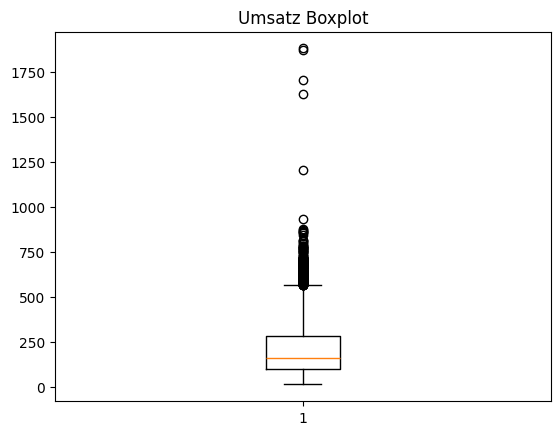

In [39]:
import matplotlib.pyplot as plt
plt.boxplot(y_train)
plt.title('Umsatz Boxplot')
plt.show()

In [23]:
df_sub

,id,Umsatz,day,month,year,Warengruppe,Datum,feiertag,brueckentag,BW,...,Monat,Monat_sin,Monat_cos,Jahr,Kalenderwoche,Tag_im_Jahr,Tag_im_Jahr_sin,Tag_im_Jahr_cos,Wochentag_sin,Wochentag_cos
0,1808011,135.833084,01,08,2018,1,2018-08-01,NaN,NaN,NaN,...,8,-8.660254e-01,-0.5,2018,31,213,-0.501242,-0.865307,0.974928,-0.222521
1,1808021,152.040466,02,08,2018,1,2018-08-02,NaN,NaN,NaN,...,8,-8.660254e-01,-0.5,2018,31,214,-0.516062,-0.856551,0.433884,-0.900969
2,1808031,145.815216,03,08,2018,1,2018-08-03,NaN,NaN,NaN,...,8,-8.660254e-01,-0.5,2018,31,215,-0.530730,-0.847541,-0.433884,-0.900969
3,1808041,523.364014,04,08,2018,1,2018-08-04,NaN,NaN,NaN,...,8,-8.660254e-01,-0.5,2018,31,216,-0.545240,-0.838280,-0.974928,-0.222521
4,1808051,83.781845,05,08,2018,1,2018-08-05,NaN,NaN,NaN,...,8,-8.660254e-01,-0.5,2018,31,217,-0.559589,-0.828770,-0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,1812226,372.367523,22,12,2018,6,2018-12-22,NaN,NaN,NaN,...,12,-2.449294e-16,1.0,2018,51,356,-0.154309,0.988023,-0.974928,-0.222521
1826,1812236,53.068741,23,12,2018,6,2018-12-23,NaN,NaN,NaN,...,12,-2.449294e-16,1.0,2018,51,357,-0.137279,0.990532,-0.781831,0.623490
1827,1812246,60.442928,24,12,2018,6,2018-12-24,NaN,NaN,NaN,...,12,-2.449294e-16,1.0,2018,52,358,-0.120208,0.992749,0.000000,1.000000
1828,1812276,57.515057,27,12,2018,6,2018-12-27,NaN,NaN,NaN,...,12,-2.449294e-16,1.0,2018,52,361,-0.068802,0.997630,0.433884,-0.900969
